In [111]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

True

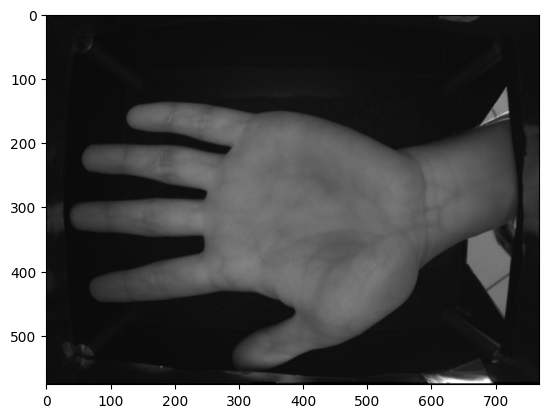

In [112]:
dataset = "/home/lucian/University/MSc-Courses/BiometricSystems/data/"
selected_person = "003"
selected_hand = "l"
selected_spectrum = "850"

pattern = f"{selected_person}_{selected_hand}_{selected_spectrum}_*.jpg"
matching_files = glob.glob(dataset + pattern)
selected_files = glob.glob(dataset + pattern)[:1]
plt.imshow(cv2.imread(selected_files[0]))
cv2.imwrite("selected_image.jpg", cv2.imread(selected_files[0]))

True

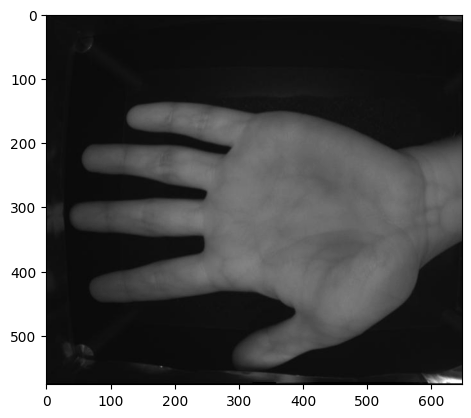

In [113]:
def load_and_crop_image(image_path):
    """
    Loads an image from the specified path and crops it by removing 120 pixels from the right side.
    """
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Crop the image by removing 120 pixels from the right side
    cropped_image = image[:, : image.shape[1] - 120]
    # Return the cropped image
    return cropped_image
cropped_image = load_and_crop_image(selected_files[0])

plt.imshow(cropped_image, cmap='gray')
cv2.imwrite('./images/cropped_image.png', cropped_image)

True

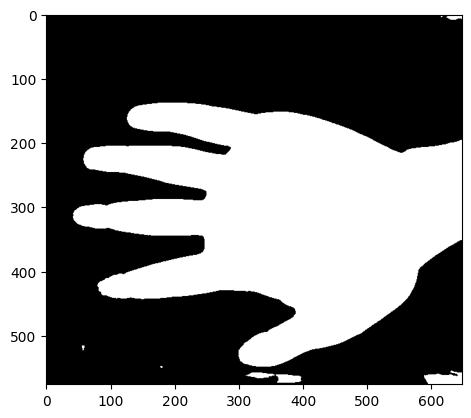

In [114]:
blurred = cv2.GaussianBlur(cropped_image, (5, 5), 0)
_, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
plt.imshow(thresholded, cmap='gray')
cv2.imwrite('./images/thresholded_image.png', thresholded)

True

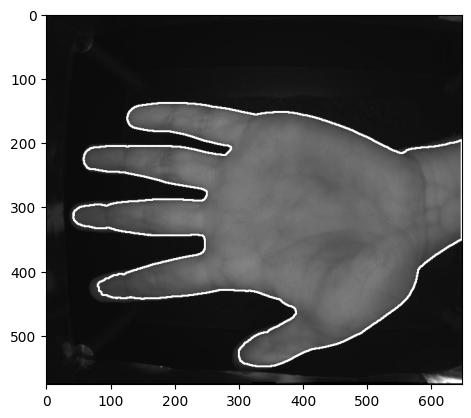

In [115]:
def preprocess_contours(image):
    """
    Preprocesses the image to find and return the largest contour.
    """
    # Apply Gaussian blur to the image to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Apply binary thresholding to the blurred image
    _, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(
        thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    # Find the largest contour based on contour area
    largest_contour = max(contours, key=cv2.contourArea)
    # Return the largest contour
    return largest_contour
largest_contour = preprocess_contours(cropped_image)
contour_image = cv2.drawContours(cropped_image.copy(), [largest_contour], 0, 255, 2)
plt.imshow(contour_image, cmap='gray')
cv2.imwrite('./images/contour_image.png', contour_image)

True

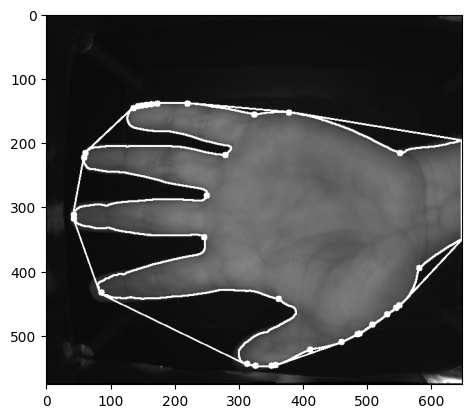

In [116]:
def find_defects(largest_contour):
    """
    Finds the convexity defects in the largest contour.
    """
    # Find the convex hull of the largest contour
    hull = cv2.convexHull(largest_contour, returnPoints=False)
    # Find the convexity defects of the largest contour using the convex hull
    defects = cv2.convexityDefects(largest_contour, hull)
    return defects

def draw_defects(image, defects, largest_contour):
    for defect in defects:
        start, end, far, _ = defect[0]
        start = tuple(largest_contour[start][0])
        end = tuple(largest_contour[end][0])
        far = tuple(largest_contour[far][0])
        cv2.line(image, start, end, 255, 2)
        cv2.circle(image, far, 5, 255, -1)
    return image

defects = find_defects(largest_contour)
defect_image = draw_defects(contour_image.copy(), defects, largest_contour)
plt.imshow(defect_image, cmap='gray')
cv2.imwrite('./images/defect_image.png', defect_image)

True

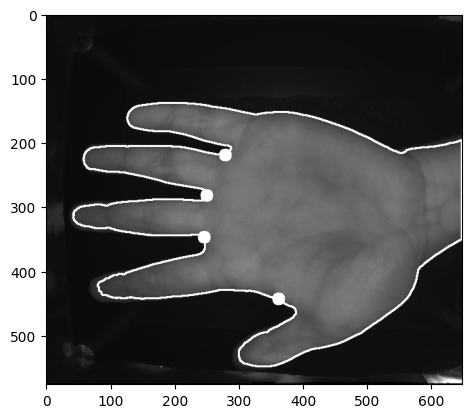

In [117]:
def get_far_points(defects, largest_contour):
    defects = sorted(defects, key=lambda x: x[0, 3], reverse=True)
    far_points = [tuple(largest_contour[defects[i][0][2]][0])for i in range(4)]
    return sorted(far_points, key=lambda point: point[1])

def draw_far_points(image, far_points):
    for point in far_points:
        cv2.circle(image, point, 10, 255, -1)
    return image

far_points = get_far_points(defects, largest_contour)
far_points_image = draw_far_points(contour_image, far_points)
plt.imshow(far_points_image, cmap='gray')
cv2.imwrite('./images/far_points_image.png', far_points_image)

True

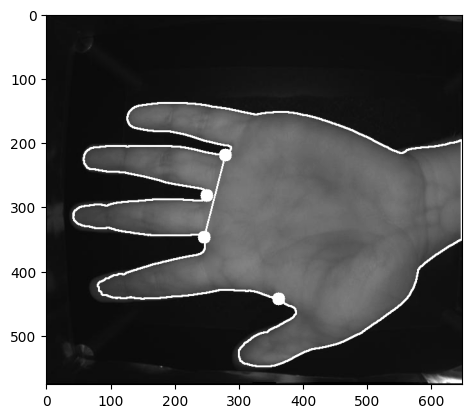

In [118]:
first_defect_far, third_defect_far = far_points[0], far_points[2]
cv2.line(far_points_image, first_defect_far, third_defect_far, 255, 2)
plt.imshow(far_points_image, cmap='gray')
cv2.imwrite('./images/far_points_line_image.png', far_points_image)

True

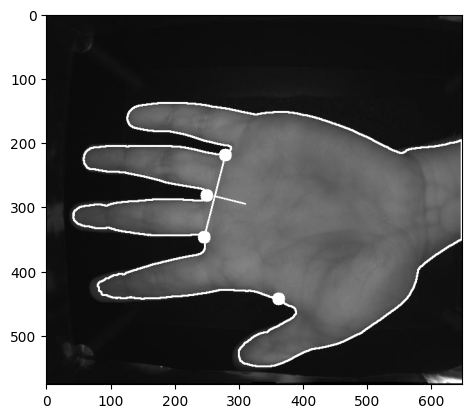

In [119]:
def compute_midpoint_and_direction(point1, point2):
    midpoint = (
        int((point1[0] + point2[0]) // 2),
        int((point1[1] + point2[1]) // 2),
    )
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length
    return midpoint, dx, dy

def compute_perpendicular_point(midpoint, dx, dy, distance=50):
    x_perpendicular = int(midpoint[0] + distance * dy)
    y_perpendicular = int(midpoint[1] - distance * dx)
    return x_perpendicular, y_perpendicular

midpoint, dx, dy = compute_midpoint_and_direction(first_defect_far, third_defect_far)
perpendicular_point = compute_perpendicular_point(midpoint, dx, dy)
cv2.line(far_points_image, midpoint,perpendicular_point, 255, 2)
plt.imshow(far_points_image, cmap='gray')
cv2.imwrite('./images/far_points_line_perpendicular_image.png', far_points_image)

True

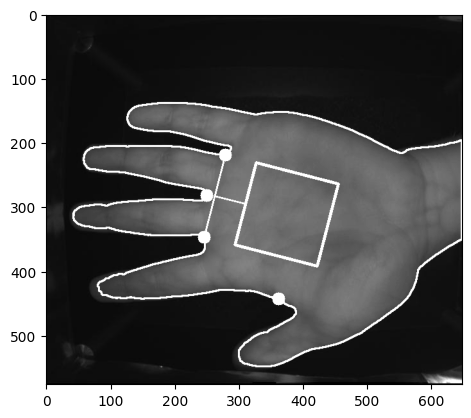

In [120]:
def generate_square_vertices(perpendicular_point, length, offset=50):
    x, y = perpendicular_point
    vertices = [
        (x + offset, y),
        (x + offset, y - length),
        (x + offset + length, y - length),
        (x + offset + length, y),
    ]
    return vertices

def calculate_length(first_defect_far, third_defect_far):
    return int(np.sqrt((third_defect_far[0] - first_defect_far[0])**2 + (third_defect_far[1] - first_defect_far[1])**2))

def rotate_square(vertices, midpoint, angle):
    rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle, scale=1)
    rotated_vertices = (
        cv2.transform(np.array([vertices], dtype=np.float32), rotation_matrix)
        .squeeze()
        .astype(np.int32)
    )
    return rotated_vertices

def translate_square(vertices, start_point):
    return vertices + start_point

def process_perpendicular_point(midpoint, perpendicular_point):
    x, y = perpendicular_point
    dx = x - midpoint[0]
    dy = y - midpoint[1]
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length
    return dx, dy

length =  calculate_length(first_defect_far, third_defect_far)
square_vertices = generate_square_vertices(perpendicular_point, length)
angle = np.arctan2(-dy, dx) * 180 / np.pi
rotated_vertices = rotate_square(square_vertices, midpoint, angle)
start_point = (first_defect_far[0] - rotated_vertices[0][0],first_defect_far[1] - rotated_vertices[0][1])
translated_vertices = translate_square(rotated_vertices, start_point)
dx_perpendicular, dy_perpendicular = process_perpendicular_point(midpoint, perpendicular_point)

translation_vector = (int(50 * dx_perpendicular), int(50 * dy_perpendicular))

translated_along_perpendicular = translated_vertices + translation_vector
cv2.polylines(far_points_image, [translated_along_perpendicular], isClosed=True, color=255, thickness=4)
plt.imshow(far_points_image, cmap='gray')
cv2.imwrite('./images/far_points_line_perpendicular_square_image.png', far_points_image)

True

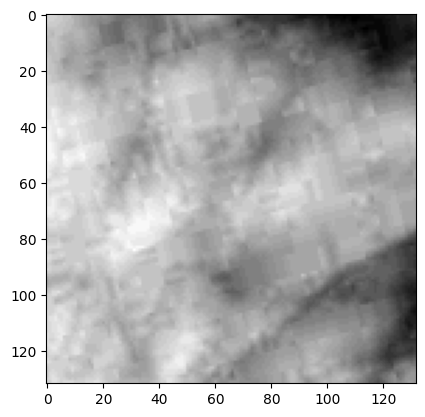

In [121]:
def compute_transform(vertices, length):
    rectified_order = np.array(
        [[0, 0], [length, 0], [length, length], [0, length]], dtype=np.float32
    )
    return cv2.getPerspectiveTransform(vertices, rectified_order)
translated_along_perpendicular = np.array(translated_along_perpendicular, dtype=np.float32)
transform_matrix = compute_transform(translated_along_perpendicular, length)
rectified_image = cv2.warpPerspective(cropped_image, transform_matrix, (length, length))
plt.imshow(rectified_image, cmap='gray')
cv2.imwrite('./images/rectified_image.png', rectified_image)

True

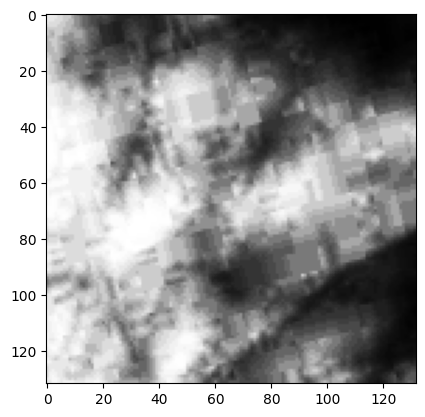

In [122]:
rectified_image_equalized = cv2.equalizeHist(rectified_image)
plt.imshow(rectified_image_equalized, cmap='gray')
cv2.imwrite('./images/rectified_image_equalized.png', rectified_image_equalized)

True

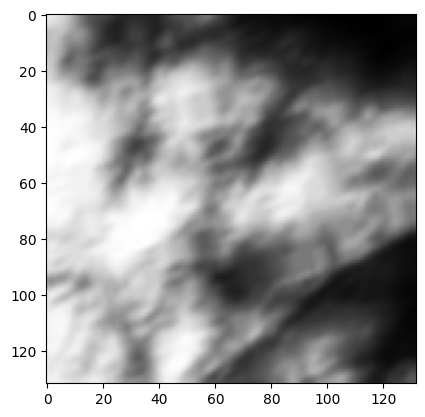

In [123]:
def apply_gabor_filter(image):
    """
    Apply a Gabor filter to the input image to enhance texture features.
    """
    # Define Gabor filter parameters
    g_kernel_size, g_sigma, g_theta, g_lambda, g_gamma, g_psi = (
        5,  # Kernel size
        2.5,  # Sigma
        np.pi / 3,  # Theta
        8.0,  # Lambda
        0.4,  # Gamma
        0.0,  # Psi
    )
    # Create Gabor kernel with the specified parameters
    gabor_kernel = cv2.getGaborKernel(
        (g_kernel_size, g_kernel_size),
        g_sigma,
        g_theta,
        g_lambda,
        g_gamma,
        g_psi,
        ktype=cv2.CV_32F,
    )
    filtered_image = cv2.filter2D(image, cv2.CV_32F, gabor_kernel)
    # Normalize the filtered image to the range [0, 255]
    return cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

gabor_filtered = apply_gabor_filter(rectified_image_equalized)
plt.imshow(gabor_filtered, cmap='gray')
cv2.imwrite('./images/gabor_filtered_image.png', gabor_filtered)


True

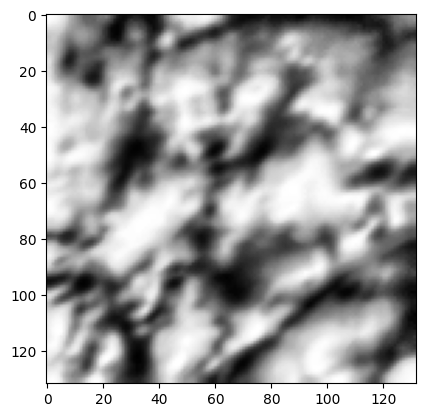

In [124]:
def enhance_contrast(image):
    """
    Enhance the contrast of the given image using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    and Gaussian blur.
    """
    # Create a CLAHE object with a clip limit of 3.0 and a tile grid size of (2, 2)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(2, 2))
    # Apply CLAHE to the input image
    enhanced_image = clahe.apply(image)
    # Apply Gaussian blur to the enhanced image with a kernel size of (5, 5)
    enhanced_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)
    # Iterate over different tile sizes [(4, 4), (8, 8), (10, 10)]
    for tile_size in [(4, 4), (8, 8), (10, 10)]:
        # Create a CLAHE object with a clip limit of 2.0 and the current tile size
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=tile_size)
        # Apply CLAHE to the enhanced image
        enhanced_image = clahe.apply(enhanced_image)
    # Return the final enhanced image
    return enhanced_image

enhanced_image = enhance_contrast(gabor_filtered)
plt.imshow(enhanced_image, cmap='gray')
cv2.imwrite('./images/enhanced_image.png', enhanced_image)

True

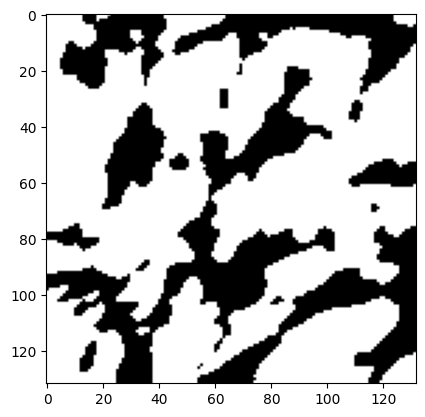

In [125]:
def binarize_image(image):
    """
    Convert the input image to a binary image using a fixed threshold.
    """
    # Apply a fixed threshold to the input image
    _, binary_image = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY)
    # Return the binarized image
    return binary_image

binarize_image = binarize_image(enhanced_image)
plt.imshow(binarize_image, cmap='gray')
cv2.imwrite('./images/binarize_image.png', binarize_image)